In [1]:
#!pip install ipywidgets > /dev/null

In [2]:
#!pip install matplotlib > /dev/null
#!pip install scikit-learn > /dev/null

In [3]:
#!pip install joblib > /dev/null

In [4]:
#!pip install category_encoders

In [5]:
#!pip install --upgrade catboost

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from numpy import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate

from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, precision_score, accuracy_score, recall_score, classification_report, PrecisionRecallDisplay, make_scorer, f1_score, average_precision_score
from sklearn.preprocessing import RobustScaler,OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import random
from sklearn.impute import SimpleImputer

import shap
import time
from lime import lime_tabular
from category_encoders import CatBoostEncoder

from model import ModelWrapper

In [7]:
np.random.seed(1)

# Data variables and basic functions

In [8]:
identity     = pd.read_csv('../datasets/teste1/train_identity.csv', usecols=['TransactionID', 'DeviceType', 'DeviceInfo'])
transactions = pd.read_csv('../datasets/teste2/train_transaction.csv', usecols=['TransactionID','TransactionAmt', 'ProductCD', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud'])

df = pd.merge(transactions, identity, on="TransactionID", how="left")
df = df.drop('TransactionID', axis=1)

df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,T,T,T,M0,F,F,F,F,F,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [9]:
classe     = df['isFraud']      
product_cd = df['ProductCD'] 
card4      = df['card4']      
card6      = df['card6']      
deviceType = df['DeviceType'] 
deviceInfo = df['DeviceInfo']
m1         = df['M1']
m2         = df['M2']
m3         = df['M3']
m4         = df['M4']
m5         = df['M5']
m6         = df['M6']
m7         = df['M7']
m8         = df['M8']
m9         = df['M9']
ta         = df['TransactionAmt']

df.drop(['isFraud', 'ProductCD', 'card4', 'card6', 'TransactionAmt', 'DeviceType', 'DeviceInfo', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], axis=1, inplace=True)
df.insert(0, 'Class', classe)
df.insert(1, 'PCD', product_cd)
df.insert(2, 'card4', card4)
df.insert(3, 'card6', card6)
df.insert(4, 'DT', deviceType)
df.insert(5, 'DI', deviceInfo)
df.insert(6, 'M1', m1)
df.insert(7, 'M2', m2)
df.insert(8, 'M3', m3)
df.insert(9, 'M4', m4)
df.insert(10, 'M5', m5)
df.insert(11, 'M6', m6)
df.insert(12, 'M7', m7)
df.insert(13, 'M8', m8)
df.insert(14, 'M9', m9)
df.insert(15, 'TA', ta)

df.head()

,Class,PCD,card4,card6,DT,DI,M1,M2,M3,M4,M5,M6,M7,M8,M9,TA,card1,card2,card3,card5
0,0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,68.5,13926,NaN,150.0,142.0
1,0,W,mastercard,credit,NaN,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,29.0,2755,404.0,150.0,102.0
2,0,W,visa,debit,NaN,NaN,T,T,T,M0,F,F,F,F,F,59.0,4663,490.0,150.0,166.0
3,0,W,mastercard,debit,NaN,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,50.0,18132,567.0,150.0,117.0
4,0,H,mastercard,credit,mobile,SAMSUNG SM-G892A Build/NRD90M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,4497,514.0,150.0,102.0


In [10]:
X = df.drop('Class', axis=1)
y = df['Class']

In [11]:
fraud_percent      = df['Class'].value_counts()[0] / len(df) * 100
not_fraud_percent = df['Class'].value_counts()[1] / len(df) * 100

print("Porcentagem de transações fraudulentas %.2f"%fraud_percent)
print("Porcentagem de transações não fraudulentas %.2f"%not_fraud_percent)

Porcentagem de transações fraudulentas 96.50
Porcentagem de transações não fraudulentas 3.50


In [12]:
data_dict = {
    'logistic_regression_values': [],
    'logistic_regression_lime': [], 
    'logistic_regression_shap': [],
    'random_forest_lime': [],
    'random_forest_shap': [],
    'svm_lime': [],
    'svm_shap': [],
    'mlp_classifier_lime': [],
    'mlp_classifier_shap': [],
    'decision_tree_lime': [],
    'decision_tree_shap': []
}

def save_model_data(model, data, method):
    if isinstance(model, LogisticRegression):
        if method == 'lime': 
            data_dict['logistic_regression_lime'].append(data)
        else:
            if method == 'shap':
                data_dict['logistic_regression_shap'].append(data)
            else:
                data_dict['logistic_regression_values'].append(data)
    elif isinstance(model, RandomForestClassifier):
        if method == 'lime': 
            data_dict['random_forest_lime'].append(data)
        else:
            data_dict['random_forest_shap'].append(data)
    elif isinstance(model, LinearSVC):
        if method == 'lime': 
            data_dict['svm_lime'].append(data)
        else:
            data_dict['svm_shap'].append(data)
    elif isinstance(model, MLPClassifier):
        if method == 'lime': 
            data_dict['mlp_classifier_lime'].append(data)
        else:
            data_dict['mlp_classifier_shap'].append(data)
    elif isinstance(model, DecisionTreeClassifier):
        if method == 'lime': 
            data_dict['decision_tree_lime'].append(data)
        else:
            data_dict['decision_tree_shap'].append(data)
    else:
        print("Unrecognized model type")

In [13]:
default_pos_color = "#008bfb"

In [14]:
def plot_results_logistic_regression_to_file(training_results):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        avg_model_coeficients = np.mean(abs(model.coef_), axis=0)
        top_indices = np.argsort(avg_model_coeficients)[::-1][:10]

        bars = axes[i].barh(np.arange(10), np.flip(avg_model_coeficients[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(avg_model_coeficients[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'reg')
    
    plt.suptitle("Regressão logística (Pesos do modelo)")
    plt.savefig("../results/new/ieee/logistic_regression_feature_importance_plot.pdf", format="pdf")
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file_for_svm(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        start = time.time()
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model._predict_proba_lr
        )
        end = time.time()
        print(f"Time used to calculate LIME values {end - start} seconds! \n")
        
        feature_names   = []
        feature_weights = []
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
          
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')

    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        start = time.time()
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model.predict_proba
        )
        end = time.time()
        print(f"Time used to calculate LIME values {end - start} seconds! \n")
        
        feature_names   = []
        feature_weights = []
        
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            le = round(np.flip(feature_weights)[j], 3)
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(le), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')
    
def plot_shap_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        start = time.time()
        model = training_results['models'][i]
        explainer   = training_results['shap_explainers'][i]
        shap_values = explainer(fraud_sample.values.reshape(1,-1)).values
        end = time.time()
        print(f"Time used to calculate SHAP values {end - start} seconds! \n")
        
        if (shap_values.ndim == 3):
            fraud_shap_values = shap_values[0][:, 1]
            fraud_shap_values_reset = pd.Series(fraud_shap_values, index=pd.Index(fraud_sample.keys()))
            fraud_shap_values_abs = np.abs(fraud_shap_values_reset.values)
            fraud_shap_values_abs = fraud_shap_values_abs.reshape(1, -1)
            mean_shap_values = fraud_shap_values_abs.mean(axis=0)
        else:
            mean_shap_values = np.abs(shap_values).mean(axis=0)

        top_indices = np.argsort(mean_shap_values)[::-1][:10]
        
        bars = axes[i].barh(np.arange(10), np.flip(mean_shap_values[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(mean_shap_values[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(    fraud_sample.keys()[top_indices]   ))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'shap')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

# Training

In [15]:
decision_tree_params = {'max_depth': [None, 5, 10], 'random_state':[1]}
random_forest_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'random_state':[1]}
logistic_regression_params = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver':['newton-cholesky'], 'max_iter':[2000, 5000], 'random_state':[1], 'n_jobs': [-1]}
svm_params = {'C': [0.1, 1, 10], 'random_state':[1], 'dual':[False]}
mlp_params = {'hidden_layer_sizes': [(100,), (50, 50)], 'max_iter':[200, 400], 'random_state':[1]}

In [16]:
decision_tree         = ModelWrapper(DecisionTreeClassifier(), decision_tree_params)
decision_tree_results = decision_tree.train(X, y, "ieee-cis")

2024-12-24 15:35:09,709 - INFO - Starting to train model DecisionTreeClassifier...
2024-12-24 15:35:10,070 - INFO - Start numerical imputation...
2024-12-24 15:35:10,761 - INFO - Finished numerical imputation. Time used: 0.69 seconds
2024-12-24 15:35:10,761 - INFO - Start categorical imputation...
2024-12-24 15:35:12,004 - INFO - Finished categorical imputation. Time used: 1.24 seconds
2024-12-24 15:35:12,005 - INFO - Start catboost encoding...
2024-12-24 15:35:15,608 - INFO - Finished catboost encoding. Time used: 3.60 seconds
2024-12-24 15:35:15,627 - INFO - Starting to scale data...
2024-12-24 15:35:15,944 - INFO - Finished scaling data. Time used: 0.32 seconds
2024-12-24 15:35:16,759 - INFO - Starting to calculate hyperparameters for DecisionTreeClassifier...
2024-12-24 15:36:38,270 - INFO - Finished hyperparameter calculation. Time used: 81.51 seconds
2024-12-24 15:36:38,271 - INFO - Best hyperparameters: {'max_depth': None, 'random_state': 1}
2024-12-24 15:37:13,748 - INFO - Star

In [17]:
print("Métricas Árvoes de Decisão: \n")

print("Sensibilidade: %f\n"%np.mean(decision_tree_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(decision_tree_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(decision_tree_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(decision_tree_results['precision_scores']))
print("F1: %f\n"%np.mean(decision_tree_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(decision_tree_results['auprc_scores']))

Métricas Árvoes de Decisão: 

Sensibilidade: 0.376713

Acurácia balanceada: 0.590607

Especificidade: 0.804502

Precisão: 0.067559

F1: 0.113993

AUPRC: 0.047289



In [18]:
logistic_regression         = ModelWrapper(LogisticRegression(), logistic_regression_params)
logistic_regression_results = logistic_regression.train(X, y, "ieee-cis")

2024-12-24 15:45:25,900 - INFO - Starting to train model LogisticRegression...
2024-12-24 15:45:26,096 - INFO - Start numerical imputation...
2024-12-24 15:45:26,757 - INFO - Finished numerical imputation. Time used: 0.66 seconds
2024-12-24 15:45:26,757 - INFO - Start categorical imputation...
2024-12-24 15:45:27,844 - INFO - Finished categorical imputation. Time used: 1.09 seconds
2024-12-24 15:45:27,845 - INFO - Start catboost encoding...
2024-12-24 15:45:31,174 - INFO - Finished catboost encoding. Time used: 3.33 seconds
2024-12-24 15:45:31,191 - INFO - Starting to scale data...
2024-12-24 15:45:31,500 - INFO - Finished scaling data. Time used: 0.31 seconds
2024-12-24 15:45:32,207 - INFO - Starting to calculate hyperparameters for LogisticRegression...
2024-12-24 15:45:45,221 - INFO - Finished hyperparameter calculation. Time used: 13.01 seconds
2024-12-24 15:45:45,222 - INFO - Best hyperparameters: {'C': 1, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 1, 'solver

In [19]:
print("Métricas Regressão Logística: \n")

print("Sensibilidade: %f\n"%np.mean(logistic_regression_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(logistic_regression_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(logistic_regression_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(logistic_regression_results['precision_scores']))
print("F1: %f\n"%np.mean(logistic_regression_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(logistic_regression_results['auprc_scores']))

Métricas Regressão Logística: 

Sensibilidade: 0.629241

Acurácia balanceada: 0.692141

Especificidade: 0.755040

Precisão: 0.085233

F1: 0.150115

AUPRC: 0.066594



In [20]:
random_forest         = ModelWrapper(RandomForestClassifier(), random_forest_params)
random_forest_results = random_forest.train(X, y, "ieee-cis")

2024-12-24 15:47:30,178 - INFO - Starting to train model RandomForestClassifier...
2024-12-24 15:47:30,376 - INFO - Start numerical imputation...
2024-12-24 15:47:31,037 - INFO - Finished numerical imputation. Time used: 0.66 seconds
2024-12-24 15:47:31,037 - INFO - Start categorical imputation...
2024-12-24 15:47:32,120 - INFO - Finished categorical imputation. Time used: 1.08 seconds
2024-12-24 15:47:32,120 - INFO - Start catboost encoding...
2024-12-24 15:47:35,445 - INFO - Finished catboost encoding. Time used: 3.32 seconds
2024-12-24 15:47:35,462 - INFO - Starting to scale data...
2024-12-24 15:47:35,776 - INFO - Finished scaling data. Time used: 0.31 seconds
2024-12-24 15:47:36,463 - INFO - Starting to calculate hyperparameters for RandomForestClassifier...
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
2024-12-24 16:42:14,016 - INFO - Finished hyperparameter calculation. Time used: 3277.55 second

In [21]:
print("Métricas Floresta Aleatória: \n")

print("Sensibilidade: %f\n"%np.mean(random_forest_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(random_forest_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(random_forest_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(random_forest_results['precision_scores']))
print("F1: %f\n"%np.mean(random_forest_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(random_forest_results['auprc_scores']))

Métricas Floresta Aleatória: 

Sensibilidade: 0.295408

Acurácia balanceada: 0.604262

Especificidade: 0.913116

Precisão: 0.139476

F1: 0.176595

AUPRC: 0.065048



In [22]:
SVM         = ModelWrapper(LinearSVC(), svm_params)
SVM_results = SVM.train(X, y, "ieee-cis")

2024-12-24 21:59:56,945 - INFO - Starting to train model LinearSVC...
2024-12-24 21:59:57,181 - INFO - Start numerical imputation...
2024-12-24 21:59:57,869 - INFO - Finished numerical imputation. Time used: 0.69 seconds
2024-12-24 21:59:57,870 - INFO - Start categorical imputation...
2024-12-24 21:59:58,948 - INFO - Finished categorical imputation. Time used: 1.08 seconds
2024-12-24 21:59:58,948 - INFO - Start catboost encoding...
2024-12-24 22:00:02,332 - INFO - Finished catboost encoding. Time used: 3.38 seconds
2024-12-24 22:00:02,349 - INFO - Starting to scale data...
2024-12-24 22:00:02,664 - INFO - Finished scaling data. Time used: 0.31 seconds
2024-12-24 22:00:03,445 - INFO - Starting to calculate hyperparameters for LinearSVC...
2024-12-24 22:00:38,150 - INFO - Finished hyperparameter calculation. Time used: 34.71 seconds
2024-12-24 22:00:38,152 - INFO - Best hyperparameters: {'C': 1, 'dual': False, 'random_state': 1}
2024-12-24 22:00:44,278 - INFO - Starting to create SHAP ex

In [23]:
print("Métricas SVM: \n")

print("Sensibilidade: %f\n"%np.mean(SVM_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(SVM_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(SVM_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(SVM_results['precision_scores']))
print("F1: %f\n"%np.mean(SVM_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(SVM_results['auprc_scores']))

Métricas SVM: 

Sensibilidade: 0.622417

Acurácia balanceada: 0.690916

Especificidade: 0.759415

Precisão: 0.085788

F1: 0.150777

AUPRC: 0.066597



In [24]:
mlp         = ModelWrapper(MLPClassifier(), mlp_params)
mlp_results = mlp.train(X, y, "ieee-cis")

2024-12-24 22:04:21,759 - INFO - Starting to train model MLPClassifier...
2024-12-24 22:04:21,958 - INFO - Start numerical imputation...
2024-12-24 22:04:22,621 - INFO - Finished numerical imputation. Time used: 0.66 seconds
2024-12-24 22:04:22,621 - INFO - Start categorical imputation...
2024-12-24 22:04:23,706 - INFO - Finished categorical imputation. Time used: 1.09 seconds
2024-12-24 22:04:23,707 - INFO - Start catboost encoding...
2024-12-24 22:04:27,046 - INFO - Finished catboost encoding. Time used: 3.34 seconds
2024-12-24 22:04:27,063 - INFO - Starting to scale data...
2024-12-24 22:04:27,383 - INFO - Finished scaling data. Time used: 0.32 seconds
2024-12-24 22:04:28,074 - INFO - Starting to calculate hyperparameters for MLPClassifier...
/home/gabriel/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home

In [25]:
print("Métricas ANN: \n")

print("Sensibilidade: %f\n"%np.mean(mlp_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(mlp_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(mlp_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(mlp_results['precision_scores']))
print("F1: %f\n"%np.mean(mlp_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(mlp_results['auprc_scores']))

Métricas ANN: 

Sensibilidade: 0.613223

Acurácia balanceada: 0.719664

Especificidade: 0.826105

Precisão: 0.115715

F1: 0.194031

AUPRC: 0.084159



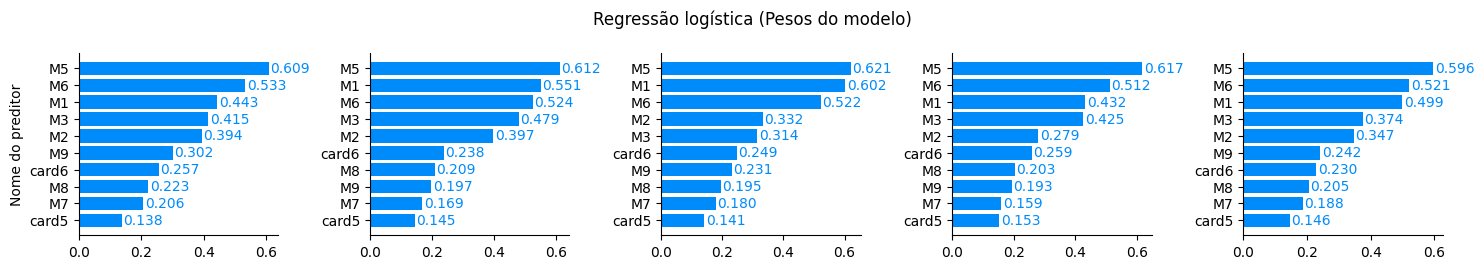

In [26]:
plot_results_logistic_regression_to_file(logistic_regression_results)

## SHAP plots

Time used to calculate SHAP values 6.778640031814575 seconds! 

Time used to calculate SHAP values 0.020806074142456055 seconds! 

Time used to calculate SHAP values 0.020137548446655273 seconds! 

Time used to calculate SHAP values 0.019762277603149414 seconds! 

Time used to calculate SHAP values 0.019664287567138672 seconds! 



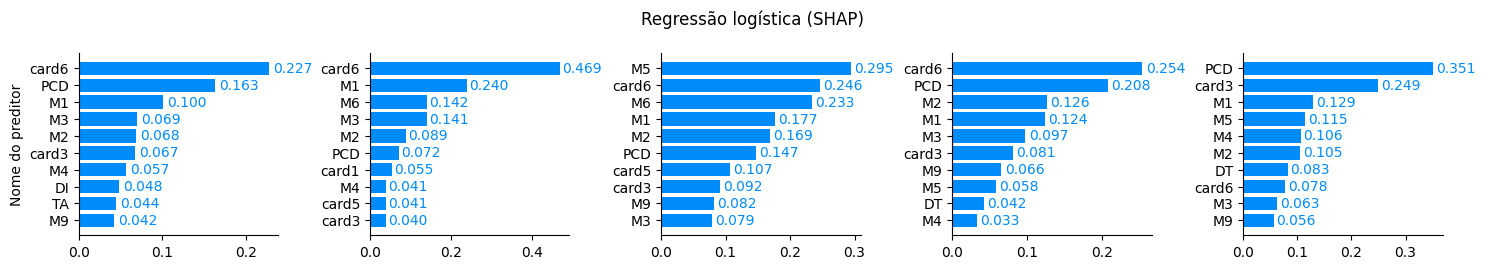

In [27]:
plot_shap_results_to_file(logistic_regression_results, "Regressão logística (SHAP)", "../results/new/ieee/logistic_regression_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.08041191101074219 seconds! 

Time used to calculate SHAP values 0.03341054916381836 seconds! 

Time used to calculate SHAP values 0.08659482002258301 seconds! 

Time used to calculate SHAP values 0.10918402671813965 seconds! 

Time used to calculate SHAP values 0.08019757270812988 seconds! 



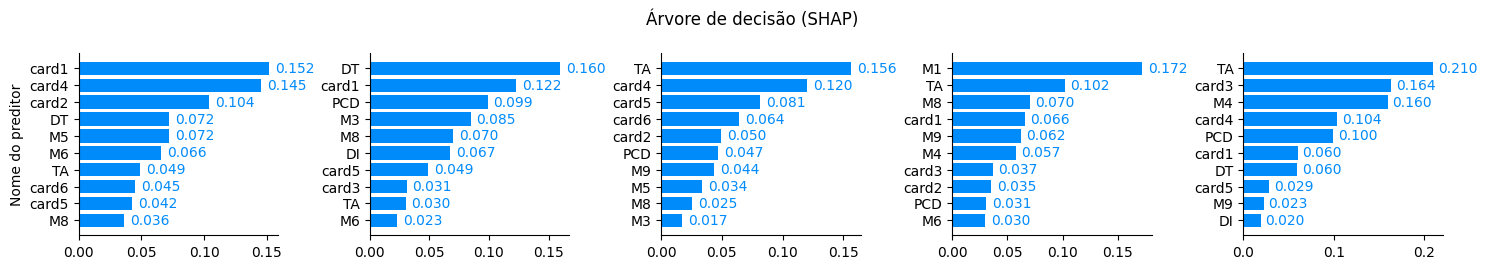

In [28]:
plot_shap_results_to_file(decision_tree_results, "Árvore de decisão (SHAP)", "../results/new/ieee/decision_tree_feature_importance_plot(shap).pdf")

Permutation explainer: 2it [00:19, 19.50s/it]                                                                                                                                          


Time used to calculate SHAP values 19.503052711486816 seconds! 



Permutation explainer: 2it [00:12, 12.96s/it]                                                                                                                                          


Time used to calculate SHAP values 12.964905500411987 seconds! 

Time used to calculate SHAP values 1.7108585834503174 seconds! 

Time used to calculate SHAP values 1.7863097190856934 seconds! 

Time used to calculate SHAP values 1.6612722873687744 seconds! 



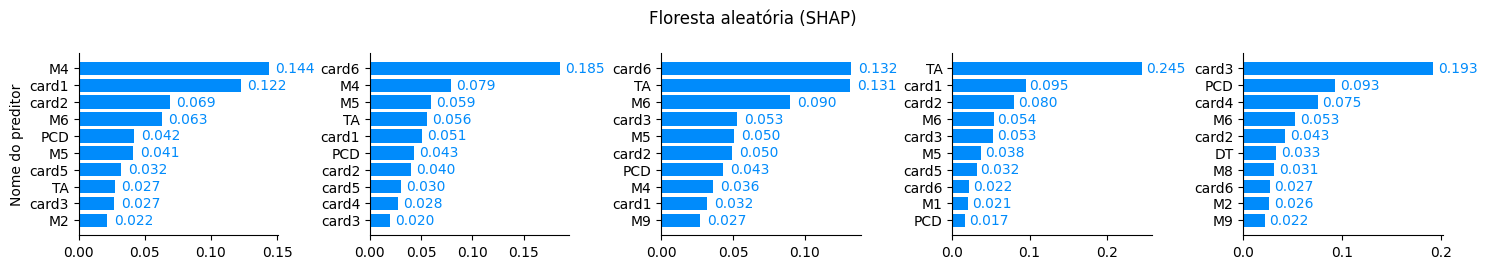

In [29]:
plot_shap_results_to_file(random_forest_results, "Floresta aleatória (SHAP)", "../results/new/ieee/random_forest_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.016979694366455078 seconds! 

Time used to calculate SHAP values 0.01630115509033203 seconds! 

Time used to calculate SHAP values 0.016238689422607422 seconds! 

Time used to calculate SHAP values 0.016858577728271484 seconds! 

Time used to calculate SHAP values 0.016149520874023438 seconds! 



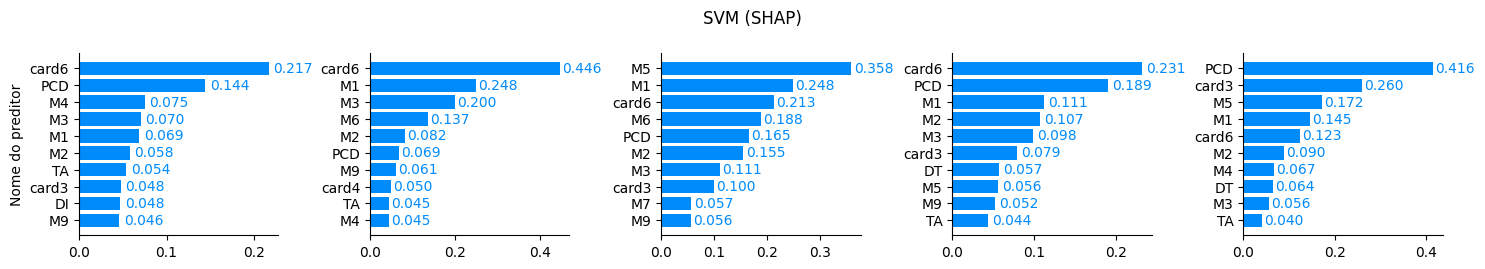

In [30]:
plot_shap_results_to_file(SVM_results, "SVM (SHAP)", "../results/new/ieee/svm_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.03339982032775879 seconds! 

Time used to calculate SHAP values 0.026822566986083984 seconds! 

Time used to calculate SHAP values 0.031832218170166016 seconds! 

Time used to calculate SHAP values 0.038721561431884766 seconds! 

Time used to calculate SHAP values 0.03736424446105957 seconds! 



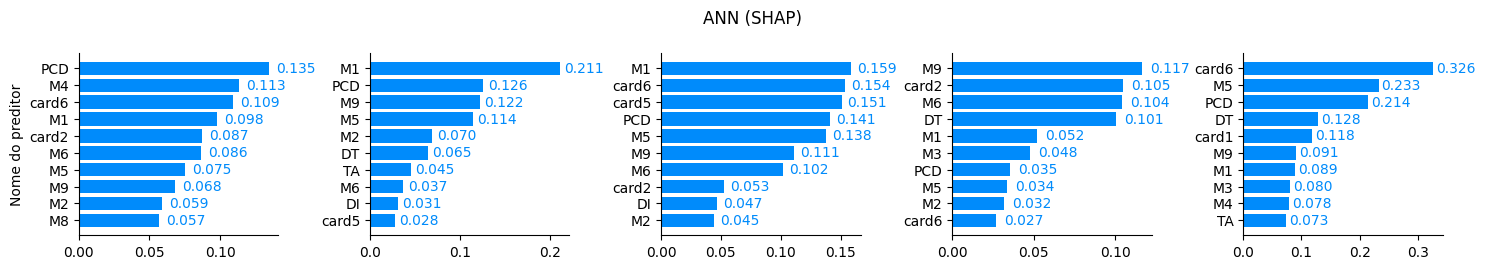

In [31]:
plot_shap_results_to_file(mlp_results, "ANN (SHAP)", "../results/new/ieee/ann_feature_importance_plot(shap).pdf")

## LIME plots

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Time used to calculate LIME values 0.0675039291381836 seconds! 

Time used to calculate LIME values 0.028636932373046875 seconds! 

Time used to calculate LIME values 0.028417587280273438 seconds! 

Time used to calculate LIME values 0.028278589248657227 seconds! 

Time used to calculate LIME values 0.028436899185180664 seconds! 



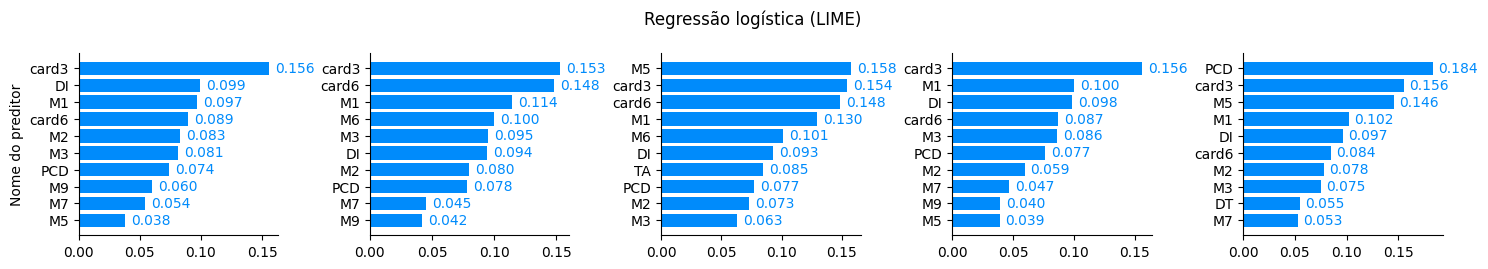

In [32]:
plot_lime_results_to_file(logistic_regression_results, "Regressão logística (LIME)", "../results/new/ieee/logistic_regression_feature_importance_plot(lime).pdf")

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Time used to calculate LIME values 0.03141927719116211 seconds! 

Time used to calculate LIME values 0.03008127212524414 seconds! 

Time used to calculate LIME values 0.03360486030578613 seconds! 

Time used to calculate LIME values 0.03351092338562012 seconds! 

Time used to calculate LIME values 0.03326749801635742 seconds! 



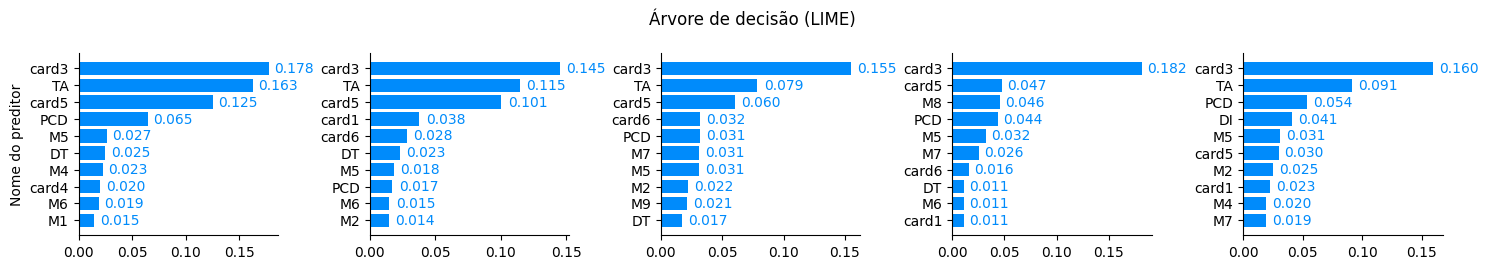

In [33]:
plot_lime_results_to_file(decision_tree_results, "Árvore de decisão (LIME)", "../results/new/ieee/decision_tree_feature_importance_plot(lime).pdf")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 2.761960029602051 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 1.9555633068084717 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.23971915245056152 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.23767566680908203 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.24027585983276367 seconds! 



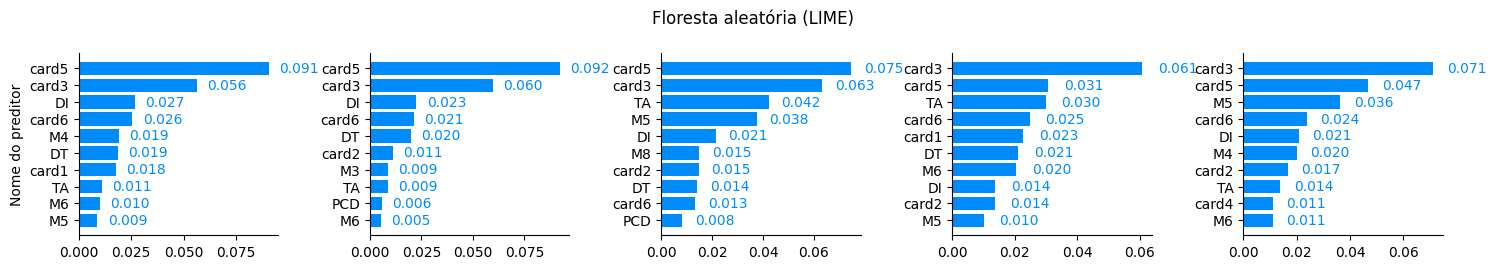

In [34]:
plot_lime_results_to_file(random_forest_results, "Floresta aleatória (LIME)", "../results/new/ieee/random_forest_feature_importance_plot(lime).pdf")

X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names


Time used to calculate LIME values 0.02769160270690918 seconds! 

Time used to calculate LIME values 0.028198719024658203 seconds! 

Time used to calculate LIME values 0.028113842010498047 seconds! 

Time used to calculate LIME values 0.028154373168945312 seconds! 

Time used to calculate LIME values 0.028174638748168945 seconds! 



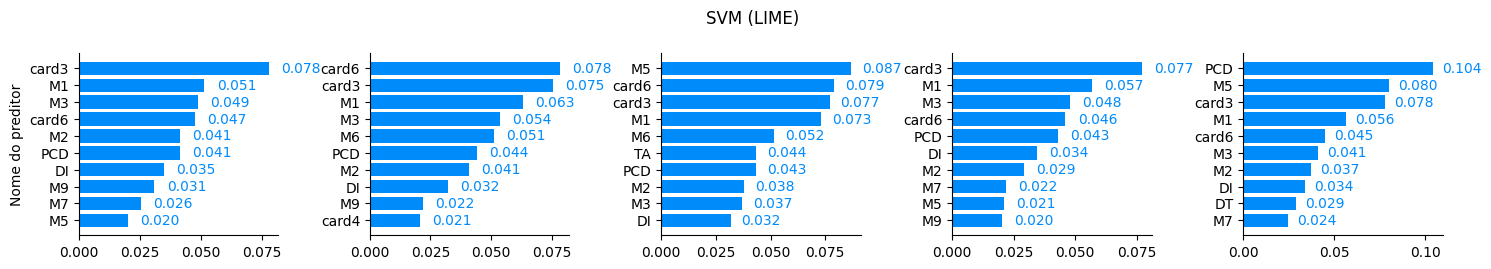

In [35]:
plot_lime_results_to_file_for_svm(SVM_results, "SVM (LIME)", "../results/new/ieee/svm_feature_importance_plot(lime).pdf")

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


Time used to calculate LIME values 0.030110836029052734 seconds! 

Time used to calculate LIME values 0.029716014862060547 seconds! 

Time used to calculate LIME values 0.030572175979614258 seconds! 

Time used to calculate LIME values 0.030631542205810547 seconds! 

Time used to calculate LIME values 0.02960944175720215 seconds! 



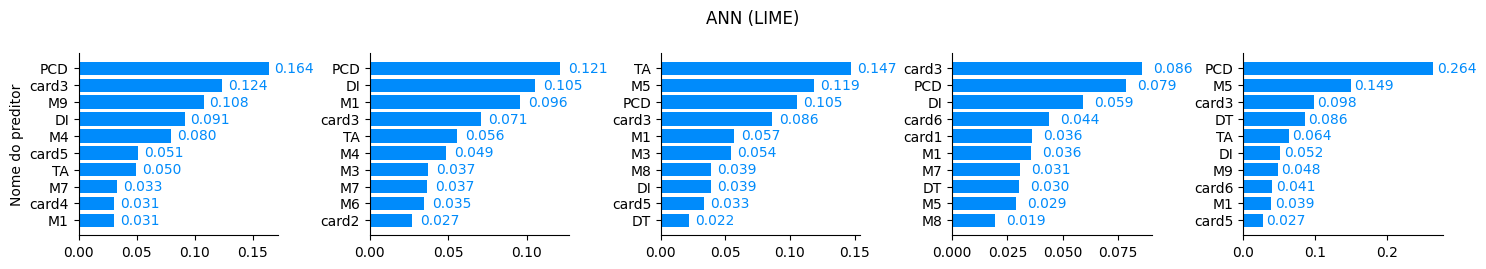

In [36]:
plot_lime_results_to_file(mlp_results, "ANN (LIME)", "../results/new/ieee/ann_feature_importance_plot(lime).pdf")

# Calculando número de acertos e erros

In [37]:
def compute_agreement(data_dict):
    logistic_regression_values = data_dict['logistic_regression_values']
    num_agreements = {}
    for key in ['logistic_regression_lime', 'logistic_regression_shap', 'random_forest_lime', 'random_forest_shap', 'svm_lime', 'svm_shap', 'mlp_classifier_lime', 'mlp_classifier_shap', 'decision_tree_lime', 'decision_tree_shap']:
        num_agreements[key] = [sum([1 for s in data_dict[key][i] if s in logistic_regression_values[i]]) for i in range(len(logistic_regression_values))]
    return num_agreements


In [38]:
res = compute_agreement(data_dict)
print(res)

{'logistic_regression_lime': [7, 7, 6, 7, 6], 'logistic_regression_shap': [5, 6, 8, 6, 6], 'random_forest_lime': [4, 4, 4, 4, 4], 'random_forest_shap': [4, 3, 4, 5, 5], 'svm_lime': [7, 6, 6, 7, 6], 'svm_shap': [5, 6, 8, 6, 5], 'mlp_classifier_lime': [4, 4, 5, 5, 5], 'mlp_classifier_shap': [7, 6, 7, 7, 5], 'decision_tree_lime': [4, 5, 6, 6, 4], 'decision_tree_shap': [5, 4, 6, 4, 2]}
